# Plot the Likelihood of Finding Cobalt Deposits in British Columbia
**By Brandon Loong, 01/21/2019**

### Load packages and data

In [1]:
# Load packages using correct env
import geopandas as gpd
import shapely.geometry as shp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import random
%matplotlib inline

# Import data
INPUT_FILE = "BedrockP.shp"
data = gpd.read_file(INPUT_FILE)

### Preview data structure, info, and columns

In [2]:
data.head(2)

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
0,33649.0,9c192ffb,4368828.0,uKPCvl,Mesozoic,Cretaceous,Upper Cretaceous,Powell Creek Formation - upper unit,None,Powell Creek Formation,...,Overlap,None,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((466212.8026486822 5669781.23969778, ..."
1,26344.0,824df15e,34431394.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,Overlap,None,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541326.0118804163 5529535.058946755,..."


In [3]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 28 columns):
gid           1596 non-null float64
upid          1596 non-null object
area_m2       1596 non-null float64
strat_unit    1596 non-null object
era           1596 non-null object
period        1596 non-null object
strat_age     1596 non-null object
strat_name    1184 non-null object
gp_suite      1036 non-null object
fm_lithodm    443 non-null object
mem_phase     76 non-null object
rock_class    1596 non-null object
rock_type     1596 non-null object
rk_char       2 non-null object
unit_desc     1596 non-null object
age_max       1596 non-null object
age_min       1596 non-null object
belt          1596 non-null object
terrane       1596 non-null object
basin         240 non-null object
basin_age     240 non-null object
project       1596 non-null object
src_url       1596 non-null object
src_ref_s     1596 non-null object
map_comp      1596 non-null object
edit_date     15

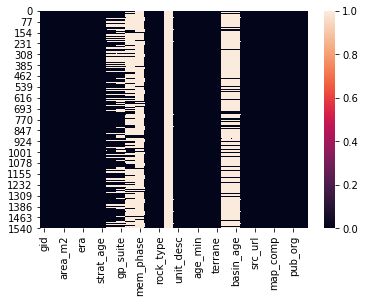

In [4]:
# View any missing data
sns.heatmap(data.isna())

**These missing data seem irrelevant to the end goal of creating heat map, so ignore for now**

In [5]:
# View some columns with granodioritic and ultramafic data
data.iloc[12:19,4:13]

,era,period,strat_age,strat_name,gp_suite,fm_lithodm,mem_phase,rock_class,rock_type
12,Paleozoic-Mesozoic,Carboniferous to Jurassic,Middle Mississippian to Middle Jurassic,Bridge River Complex,Bridge River Complex,None,None,sedimentary rocks,marine sedimentary and volcanic rocks
13,Mesozoic,Cretaceous,Lower Cretaceous,Taylor Creek Group - Lizard Formation,Taylor Creek Group,Lizard Formation,None,sedimentary rocks,undivided sedimentary rocks
14,Cenozoic,Paleogene,Eocene,Mission Ridge suite,Mission Ridge suite,None,None,intrusive rocks,granodioritic intrusive rocks
15,Cenozoic,Paleogene,Eocene,Mission Ridge suite,Mission Ridge suite,None,None,intrusive rocks,granodioritic intrusive rocks
16,Paleozoic-Mesozoic,Carboniferous to Jurassic,Middle Mississippian to Middle Jurassic,Bridge River Complex,Bridge River Complex,None,None,sedimentary rocks,marine sedimentary and volcanic rocks
17,Paleozoic,Permian,Permian,Shulaps Ultramafic Complex - Serpentinite Mela...,Shulaps Ultramafic Complex,Serpentinite Melange unit,None,ultramafic rocks,ultramafic rocks
18,Mesozoic,Jurassic to Cretaceous,Late Jurassic to Early Cretaceous,None,None,None,None,intrusive rocks,quartz dioritic intrusive rocks


**View the number of rock classes and types**

In [6]:
# Rock class counts
data['rock_class'].value_counts()

sedimentary rocks    556
intrusive rocks      455
volcanic rocks       435
metamorphic rocks    104
ultramafic rocks      46
Name: rock_class, dtype: int64

In [7]:
# Unique rock types
nrocks = data['rock_type'].nunique()
print(f"Number of rock_types: {nrocks}")

# View most common rock types and where gran/serp/ultra line up
data['rock_type'].value_counts().head(12)

Number of rock_types: 43


undivided sedimentary rocks                                  246
undivided volcanic rocks                                     149
granodioritic intrusive rocks                                147
marine sedimentary and volcanic rocks                        146
basaltic volcanic rocks                                      141
dioritic intrusive rocks                                      96
coarse clastic sedimentary rocks                              79
quartz dioritic intrusive rocks                               72
ultramafic rocks                                              46
calc-alkaline volcanic rocks                                  44
serpentinite ultramafic rocks                                 42
mudstone, siltstone, shale fine clastic sedimentary rocks     39
Name: rock_type, dtype: int64

### Create labels for the two relevant rock_types (gran + serp/ultra)

In [8]:
# Label for 1 granodioritic rock_type
allrocks = list(data['rock_type'].unique())
rocks = [x for x in allrocks if 'grano' in x]

# Labels for both ultramafic rock types
rocks.extend([x for x in allrocks if 'ultramafic' in x])
print(rocks)

['granodioritic intrusive rocks', 'ultramafic rocks', 'serpentinite ultramafic rocks']


In [9]:
# Get indexes of 2 major rock type labels
gran_idx = data['rock_type'].apply(lambda x: x == rocks[0])
serp_idx = data['rock_type'].apply(lambda x: x in rocks[1:])
all_idx = (gran_idx | serp_idx)

# Verify that sum matches value_counts() above: 147 (gran), 88 (46 ultra + 42 serp)
print(f"Total gran deposits: {sum(gran_idx)}\nTotal serp deposits: {sum(serp_idx)}")

Total gran deposits: 147
Total serp deposits: 88


### Plot only deposits with relevant rocks

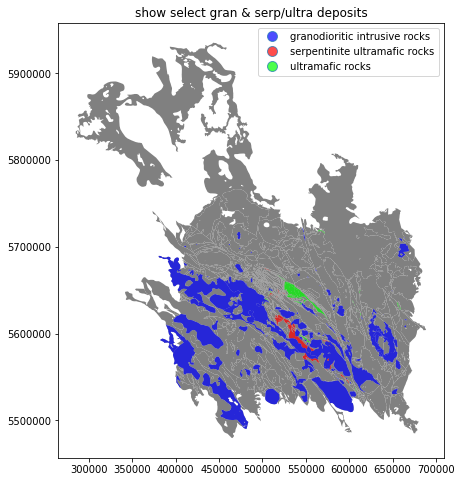

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
data.plot(ax=ax, color='grey')
data[all_idx].plot(ax=ax, column="rock_type", legend=True, cmap='brg', alpha=0.7)
ax.title.set_text('show select gran & serp/ultra deposits')

Although ultramafic and serpentinite labels are shown individually here, for the rest of the analysis, they will be combined (see instructions)

### View coordinate reference system (crs) of data set  
EPSG: 26910 (NAD83/UTM Zone 10N).

In [11]:
print(data.crs)

{'init': 'epsg:26910'}


### Calculate likelihood of finding a cobalt deposit for all regions
Find intersecting regions at a distance $r$ from relevant deposits, then assign a likelihood of finding cobalt in that region. The instructions state that the likelihood should be maximum along where granodiorite and serpentite regions touch, then fall smoothly to zero at a distance $R=10\ km$. A likelihood function that matches these goals can be described by the function
\begin{equation}L(r)=1-r/R.\end{equation}
The max distance $R$ determines when the likelihood should go to zero when $r \geq R$.

In [12]:
# Set buffer resolution, buffer distances (in meters), & blank heatdf
buffer_num = 1+10
buffer_max = 10000
distances = np.linspace(0, buffer_max, buffer_num)
heatdf = gpd.GeoDataFrame()

# Loop over buffer regions to find intersections & set equal to same likelihood
for dist in distances:
    # Enlarge regions by a buffer distance
    granbuffer = data.loc[gran_idx, 'geometry'].buffer(dist)
    serpbuffer = data.loc[serp_idx, 'geometry'].buffer(dist)
    
    # Merge all buffers into MultiPolygon, then recast as GeoDataFrame
    grantotal = gpd.GeoDataFrame({'geometry':granbuffer.unary_union, 'rock':'gran'})
    serptotal = gpd.GeoDataFrame({'geometry':serpbuffer.unary_union, 'rock':'serp'})
    
    # Get all intersecting regions between gran/serp at this dist & assign likelihood
    inter = gpd.overlay(grantotal, serptotal, how='intersection')
    inter['likelihood'] = 1 - dist/buffer_max
    
    # Store results in heatdf
    heatdf = heatdf.append(inter)

# Post-process heatdf to improve plotting & preserve crs
heatdf = heatdf.sort_values(by='likelihood', axis=0)
heatdf = heatdf.reset_index()
heatdf = heatdf.drop(labels=['index','rock_1','rock_2'], axis=1)
heatdf.crs = {'init': 'epsg:26910'}

In [13]:
# Select a random point to show likelihood at in region (if turned on)
heatdf['coords'] = heatdf['geometry'].boundary.apply(lambda x: x.representative_point().coords[:])
heatdf['coords'] = [random.choice(coords) for coords in heatdf['coords']]

### Plot heat maps
The full heat maps show that the majority of the interfacial regions between granodioritic and the serpentite/ultramafic rocks, hence, the likelihood, are in the lower portion of the plot. I will plot both the full heat map, as well as a zoomed in version to see more details.

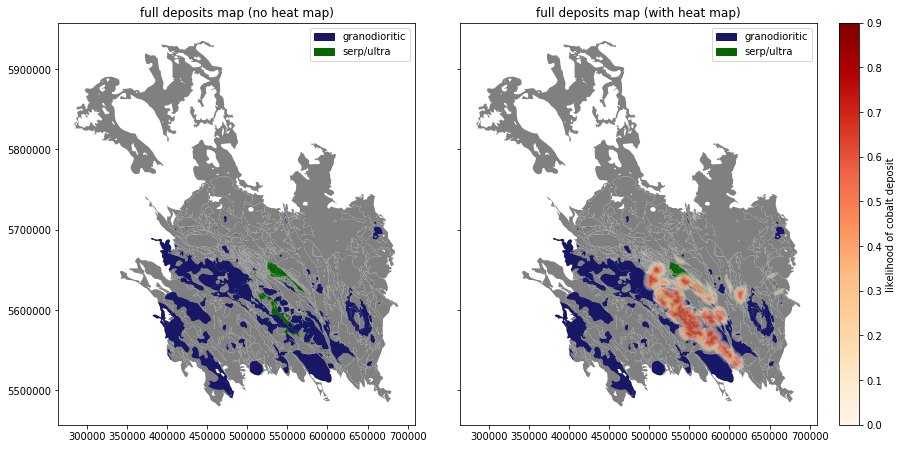

In [14]:
# Create plot variables: zoom axis limits, RGB colors, legend handles/text
xlm = [490000, 620000]
ylm = [5520000, 5680000]
gran_color = (0.09, 0.09, 0.40)    # dark blue
serp_color = (0.02, 0.40, 0.00)    # dark green
gran_patch = mpatches.Patch(color=gran_color)
serp_patch = mpatches.Patch(color=serp_color)
handles = [gran_patch, serp_patch]
leg = ['granodioritic', 'serp/ultra']

# Full deposits plot (no colorbar)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,7.4))
data.plot(ax=axs[0], color='grey')
data[gran_idx].plot(ax=axs[0], color=gran_color)
data[serp_idx].plot(ax=axs[0], color=serp_color)
axs[0].title.set_text('full deposits map (no heat map)')
axs[0].legend(handles=handles, labels=leg, loc='upper right')

# Full deposits plot (with colorbar)
data.plot(ax=axs[1], color='grey')
data[gran_idx].plot(ax=axs[1], color=gran_color)
data[serp_idx].plot(ax=axs[1], color=serp_color)
heatdf.plot(ax=axs[1], column='likelihood', alpha=0.2, cmap='OrRd')
axs[1].set_title('full deposits map (with heat map)');
axs[1].legend(handles=handles, labels=leg, loc='upper right')
plt.subplots_adjust(wspace=0.0)

# Create custom colorbar
cim = plt.cm.ScalarMappable(cmap='OrRd',
                            norm=plt.Normalize(vmin=heatdf['likelihood'].min(),
                                               vmax=heatdf['likelihood'].max()))
cbar = plt.colorbar(cim, orientation='vertical')
cbar.set_label('likelihood of cobalt deposit')
plt.subplots_adjust(wspace=0.0)

# Save figure (keep commented until ready). figsizes (20,9), (16,7.4), (13,6)
# plt.savefig('full-small.png')

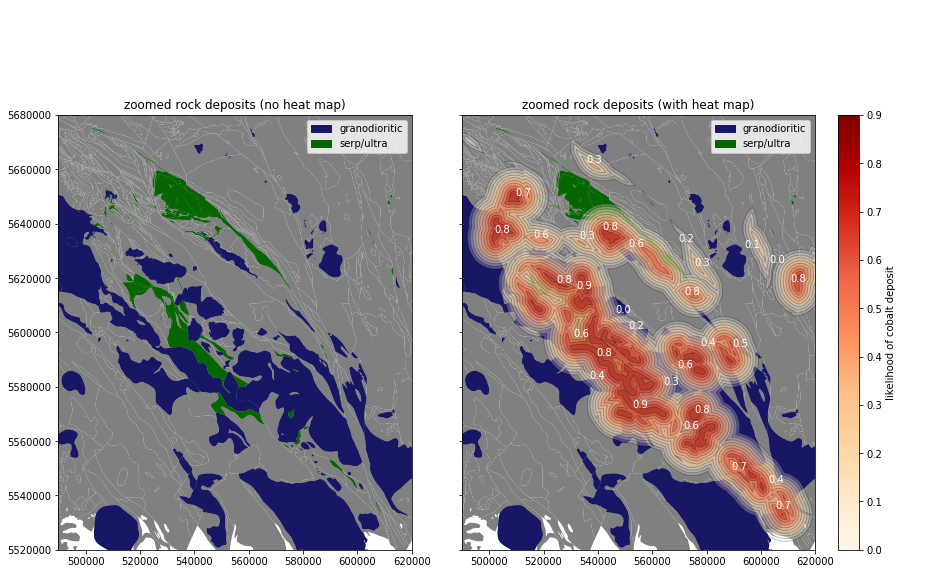

In [15]:
# Zoomed deposits plot (no colorbar)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
data.plot(ax=axs[0], color='grey')
data[gran_idx].plot(ax=axs[0], color=gran_color)
data[serp_idx].plot(ax=axs[0], color=serp_color)
axs[0].title.set_text('zoomed rock deposits (no heat map)')
axs[0].legend(handles=handles, labels=leg, loc='upper right')
axs[0].set_xlim(xlm);
axs[0].set_ylim(ylm);

# Zoomed deposits plot (with colorbar)
data.plot(ax=axs[1], color='grey')
data[gran_idx].plot(ax=axs[1], color=gran_color)
data[serp_idx].plot(ax=axs[1], color=serp_color)
heatdf.plot(ax=axs[1], column='likelihood', alpha=0.25, cmap='OrRd', edgecolor='black')
axs[1].title.set_text('zoomed rock deposits (with heat map)')
axs[1].legend(handles=handles, labels=leg, loc='upper right', fancybox=True)
axs[1].set_xlim(xlm);
axs[1].set_ylim(ylm);

# Annotate plot with a subset of likelihoods spaced out from each other
ptlist = []
for idx, row in heatdf.iterrows():
    lhood = row['likelihood']
    cpt = shp.Point(row['coords'])
    check = sum([cpt.within(pt.buffer(7000)) for pt in ptlist])
    
    # Check if coord is not within specified buffer of any point in ptlist
    if check == 0:
        ptlist.append(cpt)
        label = round(lhood, 2)
        plt.annotate(s=label, xy=row['coords'], ha='center', color='white')

# Create custom colorbar
cim = plt.cm.ScalarMappable(cmap='OrRd',
                            norm=plt.Normalize(vmin=heatdf['likelihood'].min(),
                                               vmax=heatdf['likelihood'].max()))
cbar = plt.colorbar(cim, orientation='vertical')
cbar.set_label('likelihood of cobalt deposit')
plt.subplots_adjust(wspace=0.0)

# Save figure (comment until ready). figsizes large:(20,10), med:(16,8), small:(13,6))
# plt.savefig('zoomed-med.png')

### Create a function to query exact likelihoods at any coord
The map provides a good way to quickly see general areas of high likelihood, but displaying exact likelihoods at every location cluttered the map too much. So if an exact coordinate is provided, the function below will return the numerical likelihood at that location.

In [16]:
def likelihood(coord):
    """ Given a coord tuple of (x, y), print the numerical likelihood of finding cobalt
    coord (540000, 5660000) should yield l=0.3
    coord (600000, 5540000) should yield l=0.7
    coord (578000, 5560000) should yield l=0.9
    coord (520000, 5540000) should yield l=0.0"""
    
    cpt = shp.Point(coord)
    ptwithinlist = [cpt.within(shape) for shape in heatdf['geometry']]
    hits = sum(ptwithinlist)
    
    if hits == 0:
        maxhit = 0.0
    else:
        maxhit = max(heatdf['likelihood'][ptwithinlist])
    
    print(f"The likelihood of finding cobalt at {coord} = {round(maxhit, 2)}")

In [17]:
# Test cases
likelihood((540000, 5660000))
likelihood((600000, 5540000))
likelihood((578000, 5560000))
likelihood((520000, 5540000))

The likelihood of finding cobalt at (540000, 5660000) = 0.3
The likelihood of finding cobalt at (600000, 5540000) = 0.7
The likelihood of finding cobalt at (578000, 5560000) = 0.9
The likelihood of finding cobalt at (520000, 5540000) = 0.0
